In [1]:
# Importing packages
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
from astropy.wcs import WCS
from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAperture, centroid_com, centroid_1dg, centroid_2dg
from photutils.isophote import EllipseGeometry, Ellipse
from glob import glob
import scipy
plt.rcParams["figure.figsize"] = (15,15)

%matplotlib inline

In [4]:
m91_H = fits.open('data_2019/Filtered_Images/M91_H.fits')[0].data  # opening and saving each filtered image
m91_B = fits.open('data_2019/Filtered_Images/M91_B.fits')[0].data
m91_V = fits.open('data_2019/Filtered_Images/M91_V.fits')[0].data

In [5]:
def majorMinor(major,eccentricity): # function to calculate major and minor axes in arcmins
    arcsec = major*2*0.304
    majorAxis = arcsec/60 # in arcmins
    minorAxis = majorAxis*(1-eccentricity)
    return (majorAxis,minorAxis)

def hEllipseFit(image,sma,eps,pa):
    workingImage = image[300:1500,500:1600]
    centerPoint = centroid_1dg(workingImage) # finding the center of the galaxy using a 1D gaussian distrubtion of the data
    guessEllipse = EllipseGeometry(x0=centerPoint[0],y0=centerPoint[1],sma=sma,eps=eps,pa=pa) # creating the inital guess ellipse
    ellipse = Ellipse(workingImage, guessEllipse) # instantiating an ellipse class
    isolist = ellipse.fit_image(sma0=100,maxit=70) # fitting the elipses to the image
    best_sma = isolist.sma[-1] # recording the semi major axis and ellipicity
    best_e = isolist.eps[-1]
    gradErrors = isolist.grad_error
    smaList = isolist.sma
    majorAxis, minorAxis = majorMinor(best_sma,best_e) # calculating the angular size in arcmins
    
    geometry = EllipseGeometry(x0=centerPoint[0] ,y0=centerPoint[1] , sma=best_sma, eps=best_e, pa=pa) # creating final elipse to print
    aper = EllipticalAperture((geometry.x0,geometry.y0),geometry.sma,geometry.sma*(1-geometry.eps),geometry.pa)
        
    return (majorAxis,minorAxis,smaList,gradErrors,aper)


In [6]:
H_sizes = hEllipseFit(m91_H,200,0.55,22*np.pi/180)

In [7]:
H_sizes[4]

<EllipticalAperture([517.3319186 , 557.20496814], a=313.84283767210036, b=200.24016532493883, theta=0.3839724354387525)>

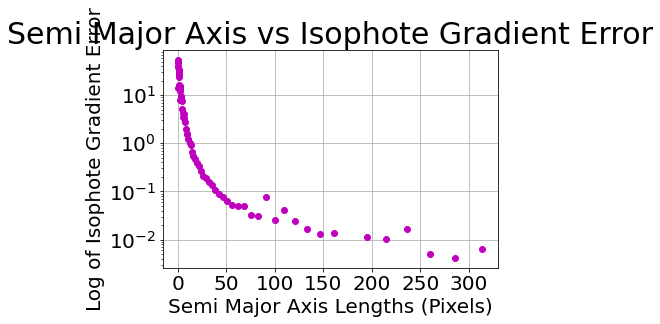

In [8]:
plt.plot(H_sizes[2],H_sizes[3],'mo') # plotting gradient error and semi major axis length
plt.xlabel('Semi Major Axis Lengths (Pixels)',fontsize=20)
plt.ylabel('Log of Isophote Gradient Error',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Semi Major Axis vs Isophote Gradient Error',fontsize=30)
plt.yscale('log')
plt.grid();
plt.savefig('m91_hGradError.eps')

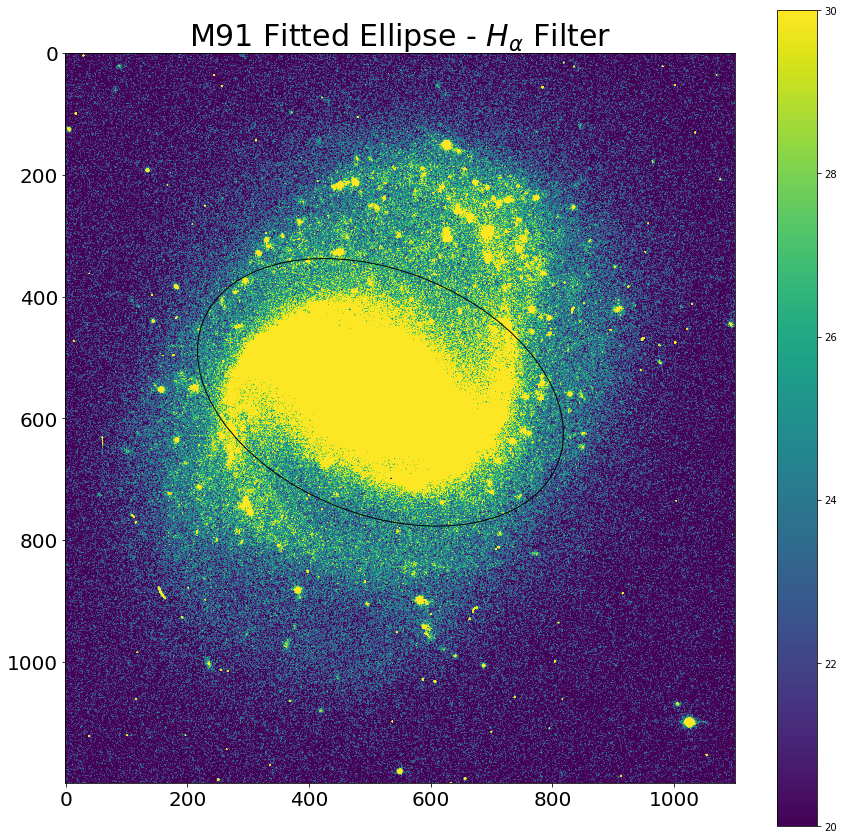

In [9]:
plt.rcParams["figure.figsize"] = (15,15) # test fit of elipse on m91 image
plt.imshow(m91_H[300:1500,500:1600],vmin=20,vmax=30)
plt.colorbar()
H_sizes[4].plot(color='black')
plt.title(r'M91 Fitted Ellipse - $H_\alpha$ Filter',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('m91_hEllipse.eps')


In [10]:
def bEllipseFit(image,sma,eps,pa):
    splitImage = np.array_split(image,4,axis=1) # splitting into three vertical segments - middle one contains galaxy
    someImage = np.concatenate((splitImage[1],splitImage[2]),axis=1)
    galaxy = np.array_split(someImage,3,axis=1)[1] # splitting again and isolating galaxy 
    workingImage = galaxy
    centerPoint = centroid_2dg(workingImage) # finding the center of the galaxy using a 2D gaussian distrubtion of the data
    guessEllipse = EllipseGeometry(x0=centerPoint[0],y0=centerPoint[1],sma=sma,eps=eps,pa=pa) # creating the inital guess ellipse
    ellipse = Ellipse(workingImage, guessEllipse) # instantiating an ellipse class
    isolist = ellipse.fit_image(sma0=100,maxit=70) # fitting the elipses to the image
    best_sma = isolist.sma[-1] # recording the semi major axis and ellipicity
    best_e = isolist.eps[-1]
    gradErrors = isolist.grad_error
    smaList = isolist.sma
    majorAxis, minorAxis = majorMinor(best_sma,best_e) # calculating the angular size in arcmins
    
    geometry = EllipseGeometry(x0=centerPoint[0] ,y0=centerPoint[1] , sma=best_sma, eps=best_e, pa=pa) # creating final elipse to print
    aper = EllipticalAperture((geometry.x0,geometry.y0),geometry.sma,geometry.sma*(1-geometry.eps),geometry.pa)
        
    return (majorAxis,minorAxis,smaList,gradErrors,aper)



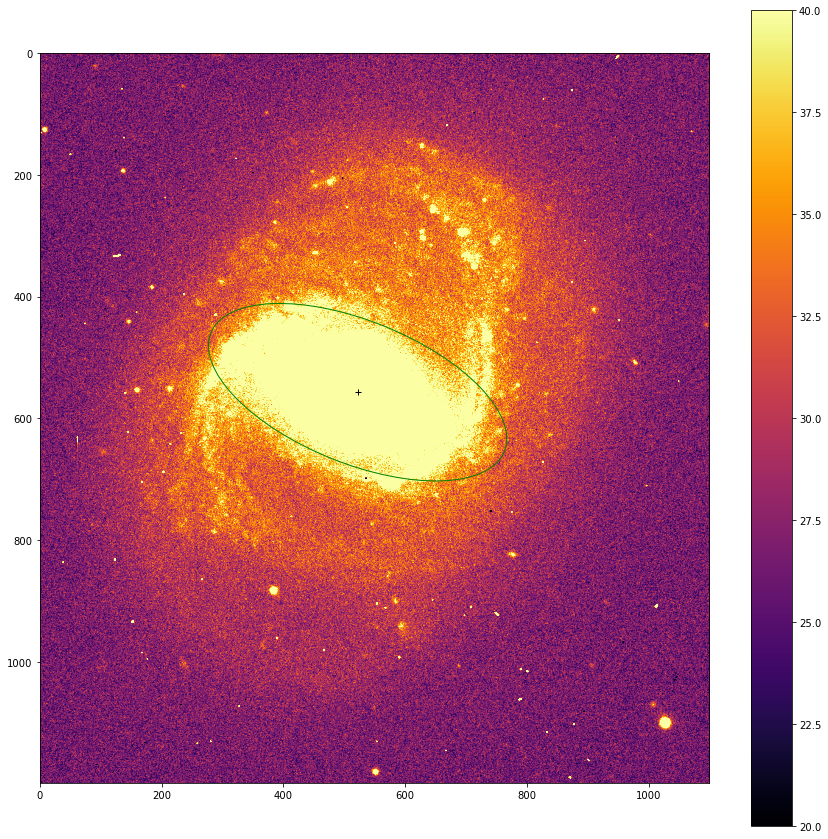

In [24]:
# For B filtered Image
# finding guess fit to start algorithm
x2,y2 = centroid_1dg(m91_B[300:1500,500:1600])
geometry1 = EllipseGeometry(x0=x2 ,y0=y2 , sma=260, eps=0.55, pa=22*np.pi/180)
aper = EllipticalAperture((geometry1.x0,geometry1.y0),geometry1.sma,geometry1.sma*(1-geometry1.eps),geometry1.pa)
marker = '+'
plt.imshow(m91_B[300:1500,500:1600],cmap='inferno',vmin=20,vmax=40)
plt.plot(x2,y2,color='black',marker=marker)
plt.colorbar()
aper.plot(color='green');

In [12]:
B_sizes = bEllipseFit(m91_B,260,0.55,22*np.pi/180)


In [14]:
B_sizes[4]

<EllipticalAperture([157.82002622, 858.60677867], a=214.3588810000002, b=106.09786224182115, theta=0.3839724354387525)>

In [15]:
# Redefining algorithm for V filter
def vEllipseFit(image,sma,eps,pa):
    splitImage = np.array_split(image,4,axis=1) # splitting into three vertical segments - middle one contains galaxy
    someImage = np.concatenate((splitImage[1],splitImage[2]),axis=1)
    galaxy = np.array_split(someImage,3,axis=0)[1] # splitting again and isolating galaxy 
    workingImage = galaxy#image
    centerPoint = centroid_1dg(workingImage) # finding the center of the galaxy using a 2D gaussian distrubtion of the data
    guessEllipse = EllipseGeometry(x0=centerPoint[0],y0=centerPoint[1],sma=sma,eps=eps,pa=pa)
    ellipse = Ellipse(workingImage, guessEllipse)
    isolist = ellipse.fit_image(maxit=70)
    best_sma = isolist.sma[-1]
    best_e = isolist.eps[-1]
    gradErrors = isolist.grad_error
    smaList = isolist.sma
    majorAxis, minorAxis = majorMinor(best_sma,best_e)
    
    geometry = EllipseGeometry(x0=centerPoint[0] ,y0=centerPoint[1] , sma=best_sma, eps=best_e, pa=pa)
    aper = EllipticalAperture((geometry.x0,geometry.y0),geometry.sma,geometry.sma*(1-geometry.eps),geometry.pa)
        
    return (majorAxis,minorAxis,smaList,gradErrors,aper)

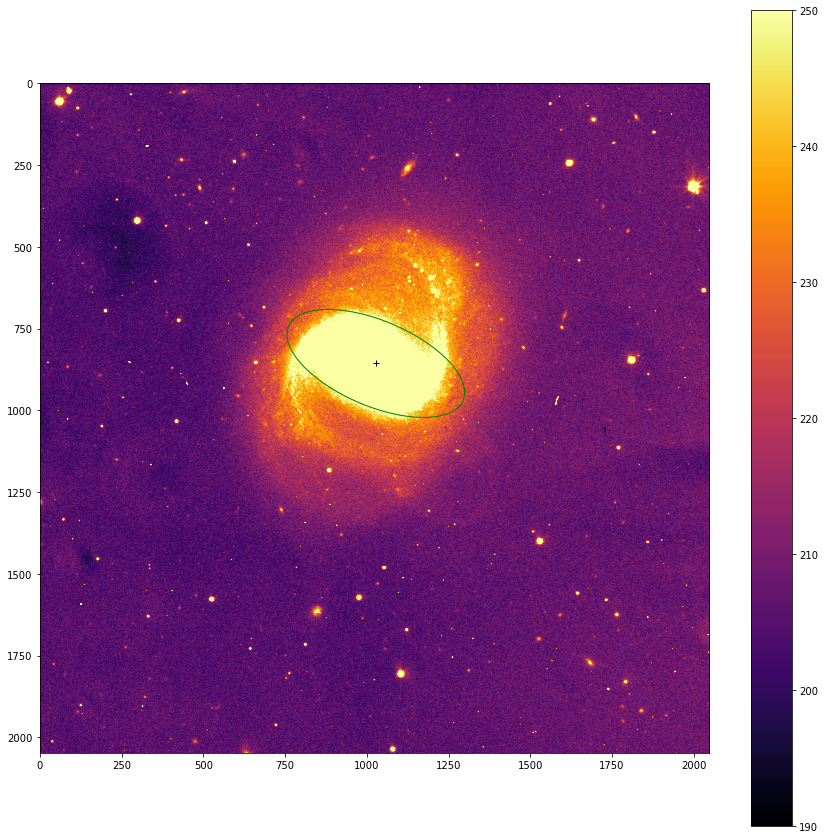

In [16]:
# For V filtered Image
# finding guess fit
x3,y3 = centroid_1dg(m91_V)
geometry2 = EllipseGeometry(x0=x3 ,y0=y3 , sma=290, eps=0.55, pa=23*np.pi/180)
aper = EllipticalAperture((geometry2.x0,geometry2.y0),geometry2.sma,geometry2.sma*(1-geometry2.eps),geometry2.pa)
marker = '+'
plt.imshow(m91_V,cmap='inferno',vmin=190,vmax=250)
plt.colorbar()
plt.plot(x3,y3,color='black',marker=marker)
aper.plot(color='green');

In [17]:
V_sizes = vEllipseFit(m91_V,290,0.55,23*np.pi/180)

In [1]:
print(f' The average major axis in arcmins is: {round(np.mean([H_sizes[0],B_sizes[0],V_sizes[0]]),3)} +/- {round(np.std([H_sizes[0],B_sizes[0],V_sizes[0]])/np.sqrt(3),3)}') # average major axis length in arcmins

NameError: name 'np' is not defined

In [21]:
H_sizes[0],B_sizes[0],V_sizes[0] # looking at major axes

(3.180274088410617, 2.172169994133335, 3.9113653333333342)

In [20]:
H_sizes[1],B_sizes[1],V_sizes[1] # looking at minor axes

(2.02910034195938, 1.075125004050454, 3.0699507367410024)

In [19]:
# Messing Around and random testing

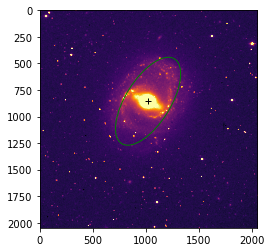

In [23]:
x1,y1 = centroid_1dg(m91_H)
geometry = EllipseGeometry(x0=x1 ,y0=y1 , sma=470, eps=0.55, pa=122*np.pi/180)
aper = EllipticalAperture((geometry.x0,geometry.y0),geometry.sma,geometry.sma*(1-geometry.eps),geometry.pa)
marker = '+'
plt.imshow(m91_H,cmap='inferno',vmin=15,vmax=50)
plt.plot(x1,y1,color='black',marker=marker)
aper.plot(color='green');

In [24]:
from photutils.isophote import Ellipse
ellipse = Ellipse(m91_H,geometry)
isolist = ellipse.fit_image()

In [25]:
table = isolist.to_table()
table

<QTable length=77>
       sma               intens            intens_err     ... niter stop_code
                                                          ...                
     float64            float64             float64       ... int64   int64  
------------------ ------------------ ------------------- ... ----- ---------
               0.0 1458.8916389738883                 0.0 ...     0         0
 0.541024848015001 1457.5439559607428 0.16446829413709566 ...    50         2
0.5951273328165011 1453.6574360964041  1.4216338930143737 ...    17         0
0.6546400660981512 1450.8284026663443  1.9139859091733367 ...    11         0
0.7201040727079663 1441.9376796568833  2.4540437194181632 ...    10         0
0.7921144799787629 1429.3337051145902  2.8574824746189043 ...    10         0
0.8713259279766393  1416.002614226481   2.938173519055079 ...    10         0
0.9584585207743033 1399.7381315721605  2.6453015757703655 ...    10         0
1.0543043728517336 1382.8946552172386  2.3797780587095128 ...    10         0
               ...                ...                 ... ...   ...       ...
 291.8330218378029 26.283455747847913 0.10973922569689322 ...    16         0
 321.0163240215832 26.899059543565315 0.32279323344708777 ...    11         0
353.11795642374153 25.416161195797024 0.06861598756420785 ...    10         0
388.42975206611567  24.06616259138853 0.05945034202213801 ...    10         0
427.27272727272725  23.45435546138326 0.13273751661349786 ...    19         0
             470.0  22.42900532698611 0.10838959106416785 ...    22         0
             517.0  21.32243156589902 0.16438463327467934 ...    12         0
             568.7  20.77621168291922 0.04732698988644162 ...    13         0
            625.57 20.295666085956405 0.04305551427886063 ...     3         5
 688.1270000000001 20.225931420176916 0.04659556995010897 ...     5         5

In [26]:
def findVertex(sma,pa):
    yPos = sma/np.sin(pa)
    xPos = sma*np.tan(pa)
    return (xPos,yPos)

angles = isolist.pa
majorAxes = isolist.sma
positions = (x1+findVertex(majorAxes,angles)[0],y1+findVertex(majorAxes,angles)[1])

plt.imshow(a[1],cmap='inferno',vmin=15,vmax=70)
plt.plot(x1,y1,color='black',marker=marker)
plt.plot(positions[0][35],positions[1][35],color='green',marker=marker);

<ipython-input-26-2c45e5a1015d>:2: RuntimeWarning: invalid value encountered in true_divide
  yPos = sma/np.sin(pa)


NameError: name 'a' is not defined

In [ ]:

for i in range(len(positions[1])):
    if positions[1][i]>=1000:
        np.delete(positions[1],i)
        np.delete(positions[0],i)

In [ ]:
plt.plot(isolist.sma,table['grad_err'],'bo')
plt.xlabel('Semi Major Axis Lengths (Pixels)')
plt.ylabel('Intensity Gradient Error')
plt.yscale('log')
plt.grid()
plt.title('Fitting Semi-Major Axis vs Graident Error');

In [ ]:
isolist.intens # this gives the mean intensity level along the isophote path

In [ ]:
isolist.grad

# This table shows the average intensity gradient of the isophotes fitted to the galaxy. 
# If we think about it, the slope would be near to zero for conintuous isophotes as that 
# would represent the most consistent connection of intensities. Hence the right ellipse would have gradient 
# to zero

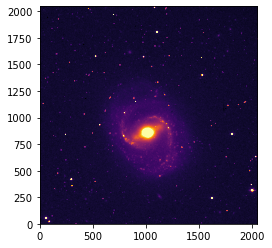

In [93]:
newImage = m91_H

#plt.gca().invert_xaxis()
plt.imshow(m91_H,cmap='inferno',vmin=15,vmax=70)
plt.gca().invert_yaxis()
